Imports

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

import shap

Paths

In [2]:
ROOT = Path("..").resolve()

DATA_PROCESSED = ROOT / "data" / "processed"
DATA_INTERIM = ROOT / "data" / "interim"
RESULTS = ROOT / "results"
FIG_DIR = ROOT / "reports" / "figures"

RESULTS.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

Load arrays and feature names.

In [3]:
# load numpy arrays (already standardized in 00_data_eda_split.ipynb)
X_train = np.load(DATA_PROCESSED / "X_train.npy")
X_val = np.load(DATA_PROCESSED / "X_val.npy")
X_test = np.load(DATA_PROCESSED / "X_test.npy")

y_train = np.load(DATA_PROCESSED / "y_train.npy")
y_val = np.load(DATA_PROCESSED / "y_val.npy")
y_test = np.load(DATA_PROCESSED / "y_test.npy")

# feature names
feat_after = DATA_INTERIM / "feature_columns_after_preprocess.json"
feat_before = DATA_INTERIM / "feature_columns.json"

if feat_after.exists():
    with open(feat_after, "r") as f:
        feature_names = json.load(f)
elif feat_before.exists():
    with open(feat_before, "r") as f:
        feature_names = json.load(f)
else:
    raise FileNotFoundError("No feature_columns* json found in data/interim/")

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape, len(feature_names)

((66403, 250), (17545, 250), (22165, 250), (66403,), (17545,), (22165,), 250)

Sanity checks

In [4]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0]   == y_val.shape[0]
assert X_test.shape[0]  == y_test.shape[0]

assert X_train.shape[1] == len(feature_names)
assert X_val.shape[1]   == len(feature_names)
assert X_test.shape[1]  == len(feature_names)

print("Sanity checks passed.")

Sanity checks passed.


In [ ]:
# combine train and val into "other" set 
X_other = np.vstack([X_train, X_val])
y_other = np.concatenate([y_train, y_val])

X_other.shape, y_other.shape

((83948, 250), (83948,))

In [ ]:
# we need groups for StratifiedGroupKFold (chemical systems)
import json

with open(DATA_INTERIM / "train_with_structure.json", "r") as f:
    train_records = json.load(f)

with open(DATA_INTERIM / "val_with_structure.json", "r") as f:
    val_records = json.load(f)

groups_train = np.array([rec["chemical_system"] for rec in train_records])
groups_val   = np.array([rec["chemical_system"] for rec in val_records])

groups_other = np.concatenate([groups_train, groups_val])

groups_train.shape, groups_val.shape, groups_other.shape

((66403,), (17545,), (83948,))

Baseline model

In [7]:
baseline_mean = float(np.mean(y_other))
print(f"Baseline constant prediction: {baseline_mean:.4f} eV")

baseline_pred_test = np.full_like(y_test, fill_value=baseline_mean, dtype=float)

baseline_mse_test  = mean_squared_error(y_test, baseline_pred_test)
baseline_rmse_test = baseline_mse_test ** 0.5
baseline_r2_test   = r2_score(y_test, baseline_pred_test)

baseline_rmse_test, baseline_r2_test

Baseline constant prediction: 1.2216 eV


(1.6163635133066605, -0.0004310368868738479)

In [8]:
# Features were already standardized in the preprocessing notebook.
# For modeling I just alias these for consistency.
X_other_scaled = X_other
X_test_scaled  = X_test

X_other_scaled.shape, X_test_scaled.shape

((83948, 250), (22165, 250))

In [ ]:
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedGroupKFold, ParameterGrid, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error


# stratification labels for band gap (deciles)
y_strat = pd.qcut(y_other, q=10, labels=False, duplicates="drop")
y_strat = np.asarray(y_strat)

# precompute 5-fold StratifiedGroupKFold splits
sgkf = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=0)

cv5_splits = list(sgkf.split(X_other_scaled, y_strat, groups_other))
n_folds = len(cv5_splits)
print(f"[INFO] Number of SGKF folds: {n_folds}")

# parallelism across folds
N_JOBS = 16

# negative MSE scorer (same as "neg_mean_squared_error")
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# place to store results
tuning_results = {}

def tune_one_model(name, base_est, param_grid):
    """
    Manual grid search with:
      - ParameterGrid over param_grid
      - 5-fold StratifiedGroupKFold
      - cross_val_score with neg MSE, converted to RMSE
    Prints per-combo progress and returns a dict of results.
    """
    grid = list(ParameterGrid(param_grid))

    print("\n" + "=" * 70)
    print(f"Starting tuning for model: {name}")
    print(f"[INFO] Param grid: {param_grid}")
    print(f"[INFO] Number of param combinations: {len(grid)}")
    print(f"[INFO] Folds per combo: {n_folds}")
    print(f"[INFO] Total fits: {len(grid) * n_folds}")
    print("=" * 70)

    combo_results = []
    best_rmse = np.inf
    best_params = None

    t_model0 = time()

    for i, params in enumerate(grid, start=1):
        # merge base params with this combo (grid params override defaults)
        combined = base_est.get_params()
        combined.update(params)
        est = base_est.__class__(**combined)

        t0 = time()
        scores = cross_val_score(
            est,
            X_other_scaled,
            y_other,
            cv=cv5_splits,
            scoring=neg_mse_scorer,
            n_jobs=N_JOBS)
        
        t1 = time()

        mse_vals = -scores               # negate back to MSE
        rmse_vals = np.sqrt(mse_vals)    # fold-wise RMSE
        mean_rmse = float(rmse_vals.mean())
        std_rmse = float(rmse_vals.std())
        elapsed = t1 - t0

        combo_results.append(
            {
                "params": params,
                "mean_rmse": mean_rmse,
                "std_rmse": std_rmse,
                "elapsed_sec": elapsed,
            })

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = params

        print(
            f"[{name}] combo {i:2d}/{len(grid):2d} "
            f"| params={params} "
            f"| mean RMSE={mean_rmse:.4f}±{std_rmse:.4f} "
            f"| time={elapsed:.1f}s")

    t_model1 = time()
    total_minutes = (t_model1 - t_model0) / 60.0

    print(f"\nFinished tuning {name} in {total_minutes:.1f} min")
    print(f"[RESULT] Best params for {name}: {best_params}")
    print(f"[RESULT] Best 5-fold CV RMSE for {name}: {best_rmse:.4f} eV")

    result = {
        "best_params": best_params,
        "best_cv_rmse": best_rmse,
        "per_combo": combo_results,
        "elapsed_min": total_minutes,
        "n_candidates": len(grid),
        "total_fits": len(grid) * n_folds,
    }
    tuning_results[name] = result
    return result

[INFO] Number of SGKF folds: 5


In [13]:
from sklearn.linear_model import Ridge

ridge_base = Ridge()
ridge_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
}

ridge_result = tune_one_model("ridge", ridge_base, ridge_grid)

ridge_result


Starting tuning for model: ridge
[INFO] Param grid: {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
[INFO] Number of param combinations: 5
[INFO] Folds per combo: 5
[INFO] Total fits: 25
[ridge] combo  1/ 5 | params={'alpha': 0.01} | mean RMSE=1.1067±0.0276 | time=2.4s
[ridge] combo  2/ 5 | params={'alpha': 0.1} | mean RMSE=1.1067±0.0276 | time=1.6s
[ridge] combo  3/ 5 | params={'alpha': 1.0} | mean RMSE=1.1067±0.0276 | time=1.6s
[ridge] combo  4/ 5 | params={'alpha': 10.0} | mean RMSE=1.1068±0.0276 | time=1.6s
[ridge] combo  5/ 5 | params={'alpha': 100.0} | mean RMSE=1.1070±0.0276 | time=0.5s

Finished tuning ridge in 0.1 min
[RESULT] Best params for ridge: {'alpha': 1.0}
[RESULT] Best 5-fold CV RMSE for ridge: 1.1067 eV


{'best_params': {'alpha': 1.0},
 'best_cv_rmse': 1.1067298957405352,
 'per_combo': [{'params': {'alpha': 0.01},
   'mean_rmse': 1.1067465650996762,
   'std_rmse': 0.027645716665606907,
   'elapsed_sec': 2.4233601093292236},
  {'params': {'alpha': 0.1},
   'mean_rmse': 1.1067438911261196,
   'std_rmse': 0.02764071100213171,
   'elapsed_sec': 1.6061921119689941},
  {'params': {'alpha': 1.0},
   'mean_rmse': 1.1067298957405352,
   'std_rmse': 0.02760477783085827,
   'elapsed_sec': 1.5541355609893799},
  {'params': {'alpha': 10.0},
   'mean_rmse': 1.1067872688833815,
   'std_rmse': 0.02758082601775474,
   'elapsed_sec': 1.5547196865081787},
  {'params': {'alpha': 100.0},
   'mean_rmse': 1.1069723365759159,
   'std_rmse': 0.02764436884227895,
   'elapsed_sec': 0.5293014049530029}],
 'elapsed_min': 0.1278197685877482,
 'n_candidates': 5,
 'total_fits': 25}

In [ ]:
N_JOBS = 1

from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(
    random_state=0,
    n_jobs=16)

rf_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [5, 10, 20],
}

rf_result = tune_one_model("rf", rf_base, rf_grid)
rf_result


Starting tuning for model: rf
[INFO] Param grid: {'n_estimators': [200, 400, 800], 'max_depth': [5, 10, 20]}
[INFO] Number of param combinations: 9
[INFO] Folds per combo: 5
[INFO] Total fits: 45
[rf] combo  1/ 9 | params={'max_depth': 5, 'n_estimators': 200} | mean RMSE=1.0586±0.0315 | time=77.6s
[rf] combo  2/ 9 | params={'max_depth': 5, 'n_estimators': 400} | mean RMSE=1.0582±0.0312 | time=153.0s
[rf] combo  3/ 9 | params={'max_depth': 5, 'n_estimators': 800} | mean RMSE=1.0587±0.0311 | time=301.5s
[rf] combo  4/ 9 | params={'max_depth': 10, 'n_estimators': 200} | mean RMSE=0.8779±0.0289 | time=136.9s
[rf] combo  5/ 9 | params={'max_depth': 10, 'n_estimators': 400} | mean RMSE=0.8774±0.0288 | time=270.1s
[rf] combo  6/ 9 | params={'max_depth': 10, 'n_estimators': 800} | mean RMSE=0.8777±0.0288 | time=531.4s
[rf] combo  7/ 9 | params={'max_depth': 20, 'n_estimators': 200} | mean RMSE=0.7372±0.0281 | time=239.5s
[rf] combo  8/ 9 | params={'max_depth': 20, 'n_estimators': 400} | mean 

{'best_params': {'max_depth': 20, 'n_estimators': 800},
 'best_cv_rmse': 0.7353143996993843,
 'per_combo': [{'params': {'max_depth': 5, 'n_estimators': 200},
   'mean_rmse': 1.0586189742042436,
   'std_rmse': 0.03151877511354393,
   'elapsed_sec': 77.62358617782593},
  {'params': {'max_depth': 5, 'n_estimators': 400},
   'mean_rmse': 1.0582209578360726,
   'std_rmse': 0.03118316262380786,
   'elapsed_sec': 152.9568908214569},
  {'params': {'max_depth': 5, 'n_estimators': 800},
   'mean_rmse': 1.0586766571041895,
   'std_rmse': 0.031149984838049934,
   'elapsed_sec': 301.49389696121216},
  {'params': {'max_depth': 10, 'n_estimators': 200},
   'mean_rmse': 0.8778546052370416,
   'std_rmse': 0.028899843303870857,
   'elapsed_sec': 136.9024932384491},
  {'params': {'max_depth': 10, 'n_estimators': 400},
   'mean_rmse': 0.8773693950862382,
   'std_rmse': 0.028774703475901168,
   'elapsed_sec': 270.1264741420746},
  {'params': {'max_depth': 10, 'n_estimators': 800},
   'mean_rmse': 0.8776762

In [ ]:
from xgboost import XGBRegressor

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=0,
    n_jobs=1)
xgb_grid = {
    "n_estimators": [300, 600],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_result = tune_one_model("xgb", xgb_base, xgb_grid)

xgb_result


Starting tuning for model: xgb
[INFO] Param grid: {'n_estimators': [300, 600], 'max_depth': [4, 6], 'learning_rate': [0.03, 0.1], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
[INFO] Number of param combinations: 32
[INFO] Folds per combo: 5
[INFO] Total fits: 160


/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

[xgb] combo  1/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8} | mean RMSE=0.8955±0.0291 | time=10.0s


/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

[xgb] combo  2/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0} | mean RMSE=0.8986±0.0288 | time=10.0s


/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

[xgb] combo  3/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.8} | mean RMSE=0.8453±0.0269 | time=17.1s


/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


[xgb] combo  4/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'subsample': 1.0} | mean RMSE=0.8533±0.0281 | time=16.7s
[xgb] combo  5/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8} | mean RMSE=0.8115±0.0246 | time=14.8s
[xgb] combo  6/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0} | mean RMSE=0.8169±0.0275 | time=15.3s
[xgb] combo  7/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8} | mean RMSE=0.7670±0.0225 | time=24.8s
[xgb] combo  8/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 600, 'subsample': 1.0} | mean RMSE=0.7747±0.0253 | time=24.9s
[xgb] combo  9/32 | params={'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8} | mean RMSE=0.8097±0

{'best_params': {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 600,
  'subsample': 0.8},
 'best_cv_rmse': 0.7119757414776784,
 'per_combo': [{'params': {'colsample_bytree': 0.8,
    'learning_rate': 0.03,
    'max_depth': 4,
    'n_estimators': 300,
    'subsample': 0.8},
   'mean_rmse': 0.8955349566102424,
   'std_rmse': 0.02913764870448259,
   'elapsed_sec': 10.043218851089478},
  {'params': {'colsample_bytree': 0.8,
    'learning_rate': 0.03,
    'max_depth': 4,
    'n_estimators': 300,
    'subsample': 1.0},
   'mean_rmse': 0.8986274225195754,
   'std_rmse': 0.028757998196313788,
   'elapsed_sec': 10.031684160232544},
  {'params': {'colsample_bytree': 0.8,
    'learning_rate': 0.03,
    'max_depth': 4,
    'n_estimators': 600,
    'subsample': 0.8},
   'mean_rmse': 0.8453162277810398,
   'std_rmse': 0.02688443463629734,
   'elapsed_sec': 17.149311065673828},
  {'params': {'colsample_bytree': 0.8,
    'learning_rate': 0.03,
    'max_depth': 4,


In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_base = MLPRegressor(
    activation="relu",
    early_stopping=True,
    max_iter=200,
    random_state=0)

mlp_grid = {
    "hidden_layer_sizes": [(100,), (200,), (100, 100)],
    "alpha": [1e-5, 1e-4, 1e-3],
}

mlp_result = tune_one_model("mlp", mlp_base, mlp_grid)

mlp_result


Starting tuning for model: mlp
[INFO] Param grid: {'hidden_layer_sizes': [(100,), (200,), (100, 100)], 'alpha': [1e-05, 0.0001, 0.001]}
[INFO] Number of param combinations: 9
[INFO] Folds per combo: 5
[INFO] Total fits: 45
[mlp] combo  1/ 9 | params={'alpha': 1e-05, 'hidden_layer_sizes': (100,)} | mean RMSE=0.8452±0.0175 | time=36.2s
[mlp] combo  2/ 9 | params={'alpha': 1e-05, 'hidden_layer_sizes': (200,)} | mean RMSE=0.8524±0.0202 | time=63.1s
[mlp] combo  3/ 9 | params={'alpha': 1e-05, 'hidden_layer_sizes': (100, 100)} | mean RMSE=0.7404±0.0119 | time=64.8s
[mlp] combo  4/ 9 | params={'alpha': 0.0001, 'hidden_layer_sizes': (100,)} | mean RMSE=0.8394±0.0185 | time=38.3s
[mlp] combo  5/ 9 | params={'alpha': 0.0001, 'hidden_layer_sizes': (200,)} | mean RMSE=0.8510±0.0180 | time=86.0s
[mlp] combo  6/ 9 | params={'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)} | mean RMSE=0.7632±0.0247 | time=66.9s
[mlp] combo  7/ 9 | params={'alpha': 0.001, 'hidden_layer_sizes': (100,)} | mean RMSE=0

{'best_params': {'alpha': 1e-05, 'hidden_layer_sizes': (100, 100)},
 'best_cv_rmse': 0.7404394288408702,
 'per_combo': [{'params': {'alpha': 1e-05, 'hidden_layer_sizes': (100,)},
   'mean_rmse': 0.8452384927985628,
   'std_rmse': 0.017455328720159417,
   'elapsed_sec': 36.19720482826233},
  {'params': {'alpha': 1e-05, 'hidden_layer_sizes': (200,)},
   'mean_rmse': 0.8524411317872026,
   'std_rmse': 0.02016985862176058,
   'elapsed_sec': 63.0519642829895},
  {'params': {'alpha': 1e-05, 'hidden_layer_sizes': (100, 100)},
   'mean_rmse': 0.7404394288408702,
   'std_rmse': 0.011859174761672215,
   'elapsed_sec': 64.76782608032227},
  {'params': {'alpha': 0.0001, 'hidden_layer_sizes': (100,)},
   'mean_rmse': 0.8394149830788986,
   'std_rmse': 0.01850421307700233,
   'elapsed_sec': 38.318469524383545},
  {'params': {'alpha': 0.0001, 'hidden_layer_sizes': (200,)},
   'mean_rmse': 0.850956805204075,
   'std_rmse': 0.01802345959425511,
   'elapsed_sec': 85.95068073272705},
  {'params': {'alpha

In [42]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
RESULTS = ROOT / "results"
RESULTS.mkdir(parents=True, exist_ok=True)

summary_rows = []

for name, res in tuning_results.items():
    summary_rows.append(
        {
            "model": name,
            "best_cv_rmse": float(res["best_cv_rmse"]),
            "best_params": res["best_params"],
            "n_candidates": res["n_candidates"],
            "total_fits": res["total_fits"],
            "elapsed_min": res["elapsed_min"],
        }
    )

tuning_summary = pd.DataFrame(summary_rows).sort_values("best_cv_rmse")
tuning_summary

,model,best_cv_rmse,best_params,n_candidates,total_fits,elapsed_min
2,xgb,0.711976,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",32,160,8.741536
3,rf,0.735314,"{'max_depth': 20, 'n_estimators': 800}",9,45,51.878704
1,mlp,0.740439,"{'alpha': 1e-05, 'hidden_layer_sizes': (100, 1...",9,45,8.448977
0,ridge,1.106730,{'alpha': 1.0},5,25,0.127820


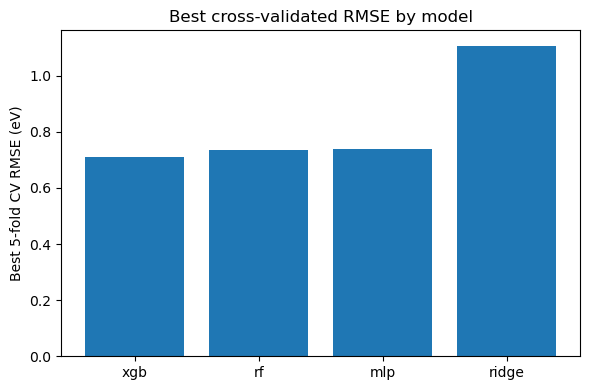

In [ ]:
# save summary table
tuning_summary.to_csv(RESULTS / "model_tuning_summary.csv", index=False)

# save just best params 
best_params_dict = {name: res["best_params"] for name, res in tuning_results.items()}
with open(RESULTS / "model_best_params.json", "w") as f:
    json.dump(best_params_dict, f, indent=2)

# Bar plot of best RMSE per model
plt.figure(figsize=(6, 4))
x = np.arange(len(tuning_summary))
rmse_vals = tuning_summary["best_cv_rmse"].values
labels = tuning_summary["model"].values

plt.bar(x, rmse_vals)
plt.xticks(x, labels)
plt.ylabel("Best 5-fold CV RMSE (eV)")
plt.title("Best cross-validated RMSE by model")

plt.tight_layout()
plt.savefig(RESULTS / "model_cv_rmse_comparison.png", dpi=300)
plt.show()

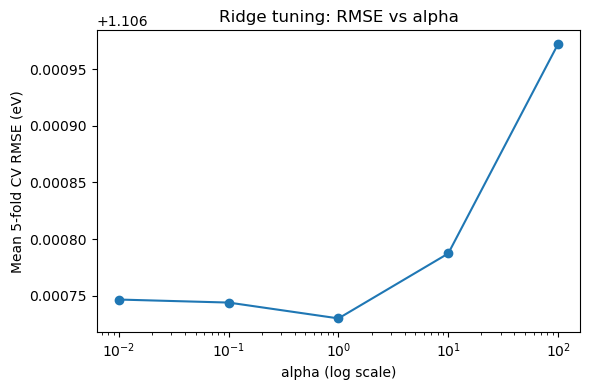

In [44]:
ridge_res = tuning_results["ridge"]
ridge_rows = []

for combo in ridge_res["per_combo"]:
    row = {
        "mean_rmse": combo["mean_rmse"],
        "std_rmse": combo["std_rmse"],
        "elapsed_sec": combo["elapsed_sec"],
        "alpha": combo["params"]["alpha"],
    }
    ridge_rows.append(row)

ridge_df = pd.DataFrame(ridge_rows).sort_values("alpha")
ridge_df

plt.figure(figsize=(6, 4))
plt.plot(ridge_df["alpha"], ridge_df["mean_rmse"], marker="o")
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Mean 5-fold CV RMSE (eV)")
plt.title("Ridge tuning: RMSE vs alpha")

plt.tight_layout()
plt.savefig(RESULTS / "ridge_tuning_curve.png", dpi=300)
plt.show()

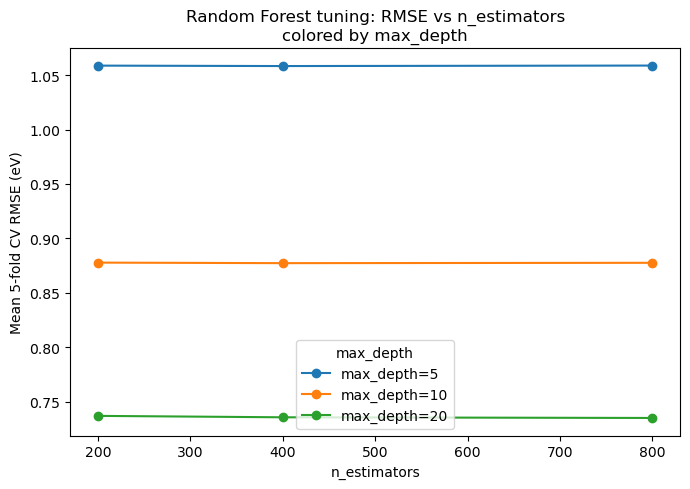

In [ ]:
rf_res = tuning_results["rf"]
rf_rows = []

for combo in rf_res["per_combo"]:
    params = combo["params"]
    rf_rows.append(
        {
            "mean_rmse": combo["mean_rmse"],
            "std_rmse": combo["std_rmse"],
            "elapsed_sec": combo["elapsed_sec"],
            "n_estimators": params["n_estimators"],
            "max_depth": params["max_depth"],
        })

rf_df = pd.DataFrame(rf_rows)
rf_df = rf_df.sort_values(["max_depth", "n_estimators"])
rf_df

plt.figure(figsize=(7, 5))

for depth in sorted(rf_df["max_depth"].unique()):
    sub = rf_df[rf_df["max_depth"] == depth]
    plt.plot(
        sub["n_estimators"],
        sub["mean_rmse"],
        marker="o",
        linestyle="-",
        label=f"max_depth={depth}")

plt.xlabel("n_estimators")
plt.ylabel("Mean 5-fold CV RMSE (eV)")
plt.title("Random Forest tuning: RMSE vs n_estimators\ncolored by max_depth")
plt.legend(title="max_depth")
plt.tight_layout()
plt.savefig(RESULTS / "rf_tuning_curves.png", dpi=300)
plt.show()

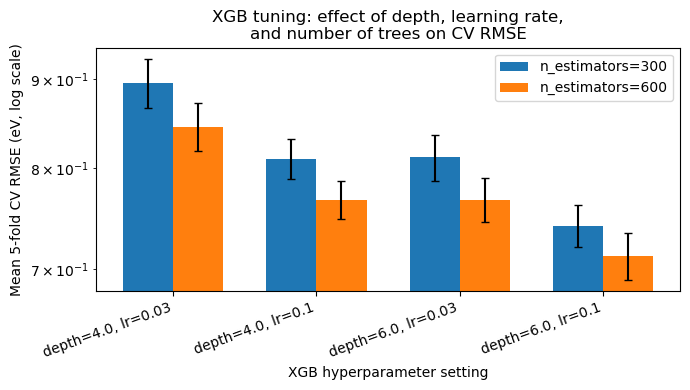

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

for j, n_est in enumerate(n_est_values):
    rmse_vals = []
    rmse_errs = []
    for d, lr in configs:
        mask = (
            (xgb_df["n_estimators"] == n_est)
            & (xgb_df["max_depth"] == d)
            & (xgb_df["learning_rate"] == lr)
        )
        row = xgb_df.loc[mask].iloc[0]
        rmse_vals.append(row["mean_rmse"])
        rmse_errs.append(row["std_rmse"])

    offset = (j - 0.5) * width
    ax.bar(
        x_pos + offset,
        rmse_vals,
        width=width,
        yerr=rmse_errs,
        capsize=3,
        label=f"n_estimators={n_est}")

ax.set_xticks(x_pos)
ax.set_xticklabels(config_labels, rotation=20, ha="right")
ax.set_ylabel("Mean 5-fold CV RMSE (eV, log scale)")
ax.set_xlabel("XGB hyperparameter setting")
ax.set_title(
    "XGB tuning: effect of depth, learning rate,\n"
    "and number of trees on CV RMSE")

ax.set_yscale("log")        

ax.legend()
plt.tight_layout()
plt.savefig(RESULTS / "xgb_tuning_barplot_log.png", dpi=300)
plt.show()

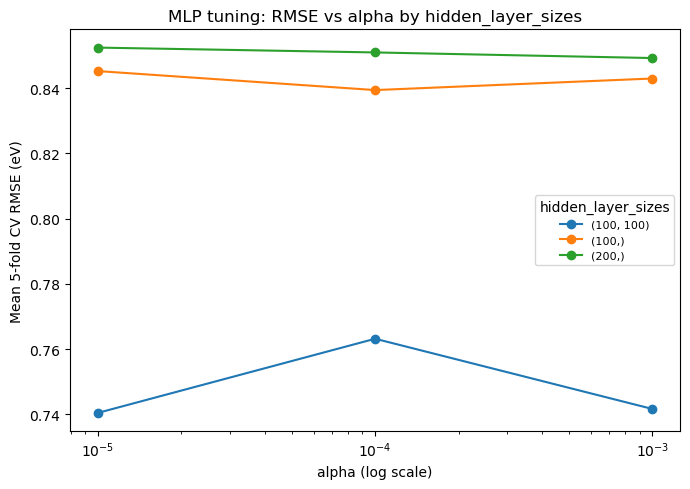

In [ ]:
mlp_res = tuning_results["mlp"]
mlp_rows = []

for combo in mlp_res["per_combo"]:
    params = combo["params"]
    mlp_rows.append(
        {
            "mean_rmse": combo["mean_rmse"],
            "std_rmse": combo["std_rmse"],
            "elapsed_sec": combo["elapsed_sec"],
            "alpha": params["alpha"],
            "hidden_layer_sizes": params["hidden_layer_sizes"],
        })

mlp_df = pd.DataFrame(mlp_rows)
mlp_df["hidden_layer_sizes_str"] = mlp_df["hidden_layer_sizes"].astype(str)
mlp_df = mlp_df.sort_values(["hidden_layer_sizes_str", "alpha"])
mlp_df

plt.figure(figsize=(7, 5))

for hls, sub in mlp_df.groupby("hidden_layer_sizes_str"):
    sub = sub.sort_values("alpha")
    plt.plot(
        sub["alpha"],
        sub["mean_rmse"],
        marker="o",
        linestyle="-",
        label=hls)

plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Mean 5-fold CV RMSE (eV)")
plt.title("MLP tuning: RMSE vs alpha by hidden_layer_sizes")
plt.legend(title="hidden_layer_sizes", fontsize=8)
plt.tight_layout()
plt.savefig(RESULTS / "mlp_tuning_curves.png", dpi=300)
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

def make_model(model_name: str):
    """
    Construct a regressor with the tuned hyperparameters
    from best_params for the given model_name.
    """
    params = best_params[model_name]

    if model_name == "ridge":
        return Ridge(**params)

    elif model_name == "rf":
        return RandomForestRegressor(
            random_state=0,
            n_jobs=16,  
            **params)

    elif model_name == "xgb":
        return XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=0,
            n_jobs=16,
            **params)

    elif model_name == "mlp":
        return MLPRegressor(
            activation="relu",
            early_stopping=True,
            max_iter=200,
            random_state=0,
            **params)

    else:
        raise ValueError(f"Unknown model_name={model_name!r}")

In [ ]:
# rebuild best_params from tuning_results to avoid any accidental overwrites
best_params = {}

for name, res in tuning_results.items():
    bp = res.get("best_params", None)
    if bp is None:
        raise ValueError(f"[ERROR] No best_params stored for model '{name}'. "
                         "Did tuning for this model run successfully?")
    best_params[name] = bp

best_params

{'ridge': {'alpha': 1.0},
 'mlp': {'alpha': 1e-05, 'hidden_layer_sizes': (100, 100)},
 'xgb': {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 600,
  'subsample': 0.8},
 'rf': {'max_depth': 20, 'n_estimators': 800}}

In [53]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

def make_model(model_name: str):
    """
    Construct a regressor with the tuned hyperparameters
    from best_params for the given model_name.
    """
    if model_name not in best_params:
        raise ValueError(f"Model '{model_name}' not found in best_params keys: {list(best_params.keys())}")

    params = best_params[model_name]

    if model_name == "ridge":
        return Ridge(**params)

    elif model_name == "rf":
        return RandomForestRegressor(
            random_state=0,
            n_jobs=16,   # use all cores on Oscar for final training
            **params,
        )

    elif model_name == "xgb":
        return XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=0,
            n_jobs=16,
            **params,
        )

    elif model_name == "mlp":
        return MLPRegressor(
            activation="relu",
            early_stopping=True,
            max_iter=200,
            random_state=0,
            **params,
        )

    else:
        raise ValueError(f"Unknown model_name={model_name!r}")

In [54]:
from joblib import dump
from pathlib import Path

MODELS = ROOT / "models"
MODELS.mkdir(parents=True, exist_ok=True)

model_names = ["ridge", "rf", "xgb", "mlp"]
saved_models = {}

for name in model_names:
    print(f"\n[TRAIN] Fitting tuned {name} on train+val (X_other_scaled)...")
    model = make_model(name)
    model.fit(X_other_scaled, y_other)

    out_path = MODELS / f"{name}_tuned.joblib"
    dump(model, out_path)

    print(f"[SAVE] Saved {name} model to {out_path}")
    saved_models[name] = model


[TRAIN] Fitting tuned ridge on train+val (X_other_scaled)...
[SAVE] Saved ridge model to /oscar/scratch/eivanias/band_gap_project/models/ridge_tuned.joblib

[TRAIN] Fitting tuned rf on train+val (X_other_scaled)...
[SAVE] Saved rf model to /oscar/scratch/eivanias/band_gap_project/models/rf_tuned.joblib

[TRAIN] Fitting tuned xgb on train+val (X_other_scaled)...
[SAVE] Saved xgb model to /oscar/scratch/eivanias/band_gap_project/models/xgb_tuned.joblib

[TRAIN] Fitting tuned mlp on train+val (X_other_scaled)...
[SAVE] Saved mlp model to /oscar/scratch/eivanias/band_gap_project/models/mlp_tuned.joblib


In [ ]:
from joblib import load
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_names = ["ridge", "rf", "xgb", "mlp"]

MODELS = ROOT / "models"
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# load tuned models 
models_eval = {}
for name in model_names:
    path = MODELS / f"{name}_tuned.joblib"
    if not path.exists():
        raise FileNotFoundError(f"Expected tuned model not found: {path}")
    models_eval[name] = load(path)

# compute test metrics for each model
rows = []
for name, model in models_eval.items():
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    rows.append({
        "model": name,
        "rmse_test": float(rmse),
        "r2_test": float(r2),
    })

test_summary = pd.DataFrame(rows).sort_values("rmse_test")
test_summary

,model,rmse_test,r2_test
2,xgb,0.714734,0.804387
3,mlp,0.738400,0.791218
1,rf,0.745848,0.786985
0,ridge,1.080038,0.553330


In [ ]:
# Add baseline row
baseline_row = pd.DataFrame([{
    "model": "baseline_mean",
    "rmse_test": float(baseline_rmse_test),
    "r2_test": float(baseline_r2_test),
}])

test_summary_with_baseline = pd.concat(
    [baseline_row, test_summary],
    ignore_index=True)

test_summary_with_baseline.to_csv(
    RESULTS / "model_test_scores_with_baseline.csv",
    index=False)

test_summary_with_baseline

,model,rmse_test,r2_test
0,baseline_mean,1.616364,-0.000431
1,xgb,0.714734,0.804387
2,mlp,0.738400,0.791218
3,rf,0.745848,0.786985
4,ridge,1.080038,0.553330


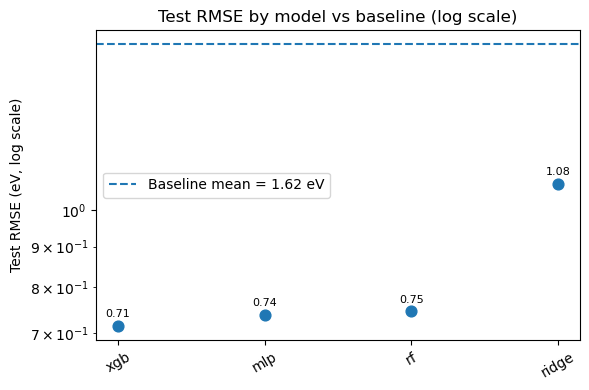

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df = test_summary_with_baseline.copy()

baseline_rmse = df.loc[df["model"] == "baseline_mean", "rmse_test"].iloc[0]
models_df = df[df["model"] != "baseline_mean"].copy()

models_df = models_df.sort_values("rmse_test", ascending=True)

x = np.arange(len(models_df))
rmse_vals = models_df["rmse_test"].values
labels = models_df["model"].values

plt.figure(figsize=(6, 4))

# Scatter for tuned models
plt.scatter(x, rmse_vals, s=60)  

plt.axhline(
    baseline_rmse,
    linestyle="--",
    linewidth=1.5,
    label=f"Baseline mean = {baseline_rmse:.2f} eV")

plt.yscale("log")  
plt.xticks(x, labels, rotation=30)
plt.ylabel("Test RMSE (eV, log scale)")
plt.title("Test RMSE by model vs baseline (log scale)")

for xi, v in zip(x, rmse_vals):
    plt.text(xi, v * 1.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.legend()
plt.tight_layout()
plt.savefig(RESULTS / "model_test_rmse_scatter_vs_baseline_log.png", dpi=300)
plt.show()

In [ ]:
# best model
if "best_cv_rmse" in tuning_summary.columns:
    cv_metric_col = "best_cv_rmse"
elif "cv_rmse_mean" in tuning_summary.columns:
    cv_metric_col = "cv_rmse_mean"
else:
    raise ValueError("tuning_summary must have 'best_cv_rmse' or 'cv_rmse_mean'.")

best_row = tuning_summary.sort_values(cv_metric_col).iloc[0]
best_model_name = best_row["model"]
best_model_name

'xgb'

In [59]:
best_model = models_eval[best_model_name]

y_test_pred = best_model.predict(X_test_scaled)

best_mse_test = mean_squared_error(y_test, y_test_pred)
best_rmse_test = best_mse_test ** 0.5
best_r2_test = r2_score(y_test, y_test_pred)

print(f"Best model by CV: {best_model_name}")
print(f"Test RMSE: {best_rmse_test:.4f} eV")
print(f"Test R²  : {best_r2_test:.4f}")
print(f"Baseline test RMSE: {baseline_rmse_test:.4f} eV")
print(f"Baseline test R²  : {baseline_r2_test:.4f}")

Best model by CV: xgb
Test RMSE: 0.7147 eV
Test R²  : 0.8044
Baseline test RMSE: 1.6164 eV
Baseline test R²  : -0.0004


In [ ]:
test_results_df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_test_pred,
    "abs_error": np.abs(y_test_pred - y_test),
})
test_results_df.to_csv(
    RESULTS / f"{best_model_name}_test_predictions.csv",
    index=False)

test_results_df.head()

,y_test,y_pred,abs_error
0,0.0,-0.016776,0.016776
1,0.0,0.380051,0.380051
2,0.0,-0.120064,0.120064
3,0.0,-0.089069,0.089069
4,0.0,-0.144933,0.144933


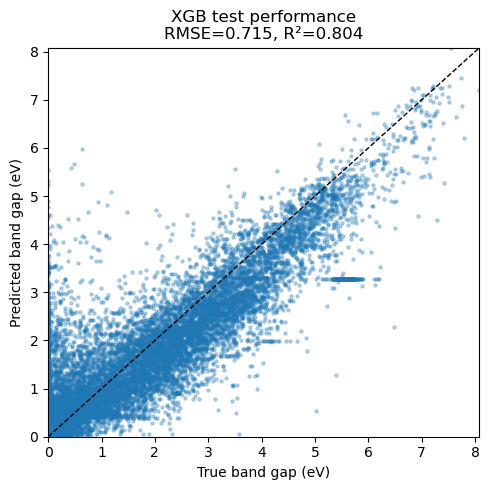

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(y_test, y_test_pred, s=5, alpha=0.3)

lims = [0.0, max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims, "k--", linewidth=1)

plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True band gap (eV)")
plt.ylabel("Predicted band gap (eV)")
plt.title(
    f"{best_model_name.upper()} test performance\n"
    f"RMSE={best_rmse_test:.3f}, R²={best_r2_test:.3f}")

plt.tight_layout()
plt.savefig(RESULTS / f"{best_model_name}_test_true_vs_pred.png", dpi=300)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

N_JOBS_PERM = 8  

perm = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    n_jobs=N_JOBS_PERM,
    random_state=0)

perm_means = perm.importances_mean
perm_stds = perm.importances_std

perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm_means,
    "importance_std": perm_stds,
}).sort_values("importance_mean", ascending=False)

perm_df.head(10)

/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/users/eivanias/.conda/envs/bandgap/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

,feature,importance_mean,importance_std
7,O,0.131690,0.003396
193,MagpieData mean NValence,0.120391,0.002803
141,MagpieData mode MeltingT,0.067961,0.001428
179,MagpieData maximum NdValence,0.060085,0.001190
181,MagpieData mean NdValence,0.057617,0.001148
175,MagpieData mean NpValence,0.033224,0.000709
28,Cu,0.026801,0.000682
157,MagpieData mean CovalentRadius,0.020227,0.000287
62,Eu,0.019414,0.000634
146,MagpieData avg_dev Column,0.016889,0.000463


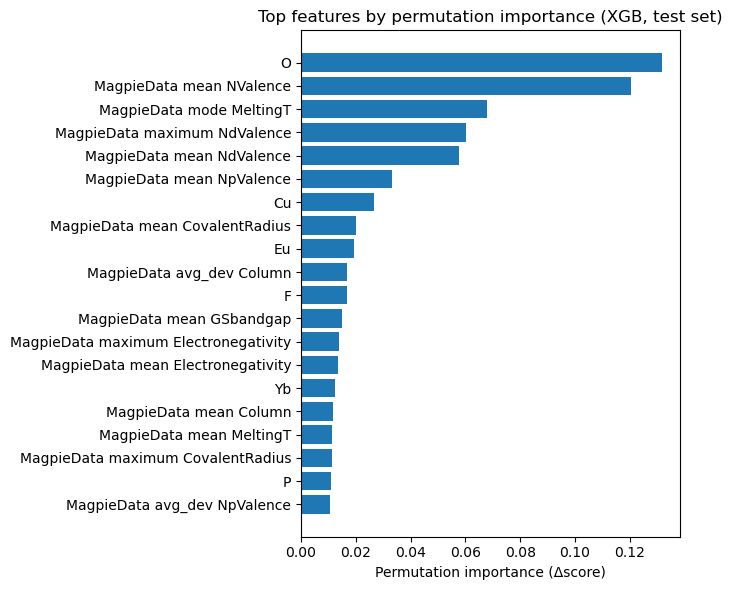

In [64]:
top_k = 20
top_perm = perm_df.head(top_k).iloc[::-1]

plt.figure(figsize=(7, 6))
plt.barh(top_perm["feature"], top_perm["importance_mean"])
plt.xlabel("Permutation importance (Δscore)")
plt.title(f"Top features by permutation importance ({best_model_name.upper()}, test set)")
plt.tight_layout()
plt.savefig(RESULTS / f"{best_model_name}_perm_importance_top20.png", dpi=300)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

top_k = 20 

xgb_importances = best_model.feature_importances_

xgb_mdi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_importances,
}).sort_values("importance", ascending=False)

xgb_mdi_df.head(10)

,feature,importance
141,MagpieData mode MeltingT,0.239673
161,MagpieData maximum Electronegativity,0.185169
179,MagpieData maximum NdValence,0.059499
216,MagpieData range NfUnfilled,0.045628
143,MagpieData maximum Column,0.036831
215,MagpieData maximum NfUnfilled,0.032597
181,MagpieData mean NdValence,0.021454
28,Cu,0.017002
180,MagpieData range NdValence,0.013324
125,MagpieData maximum MendeleevNumber,0.012982


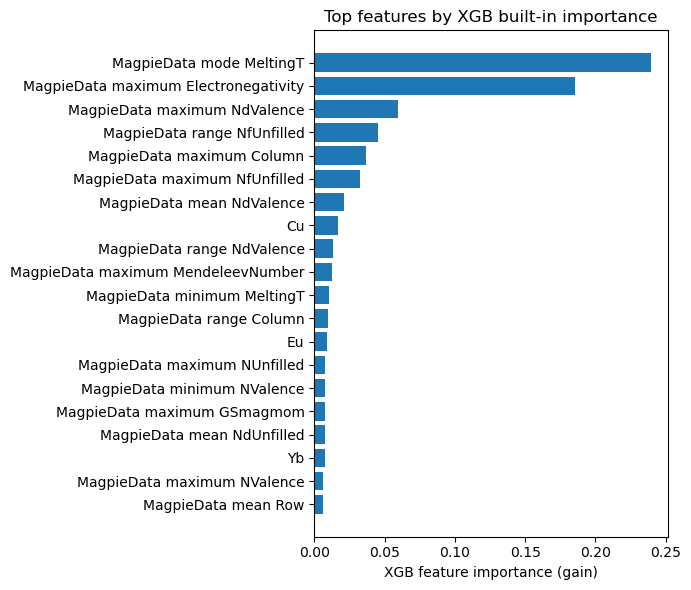

In [ ]:
top_mdi = xgb_mdi_df.head(top_k).iloc[::-1]  

plt.figure(figsize=(7, 6))
plt.barh(top_mdi["feature"], top_mdi["importance"])
plt.xlabel("XGB feature importance (gain)")
plt.title("Top features by XGB built-in importance")
plt.tight_layout()
plt.savefig(RESULTS / "xgb_gain_importance_top20.png", dpi=300)
plt.show()

In [79]:
import shap
import numpy as np

n_shap = 2000
rng = np.random.default_rng(0)
idx = rng.choice(len(X_test_scaled), size=n_shap, replace=False)

X_shap = X_test_scaled
y_shap = y_test

X_shap.shape, y_shap.shape


explainer = shap.TreeExplainer(best_model)  
shap_values = explainer.shap_values(X_shap)

shap_values.shape

(22165, 250)

In [80]:
shap_abs_mean = np.mean(np.abs(shap_values), axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": shap_abs_mean,
}).sort_values("mean_abs_shap", ascending=False)

shap_df.head(10)

,feature,mean_abs_shap
141,MagpieData mode MeltingT,0.293987
181,MagpieData mean NdValence,0.164564
161,MagpieData maximum Electronegativity,0.130232
179,MagpieData maximum NdValence,0.120752
7,O,0.119960
175,MagpieData mean NpValence,0.103591
28,Cu,0.066384
157,MagpieData mean CovalentRadius,0.063771
193,MagpieData mean NValence,0.063587
151,MagpieData mean Row,0.062404


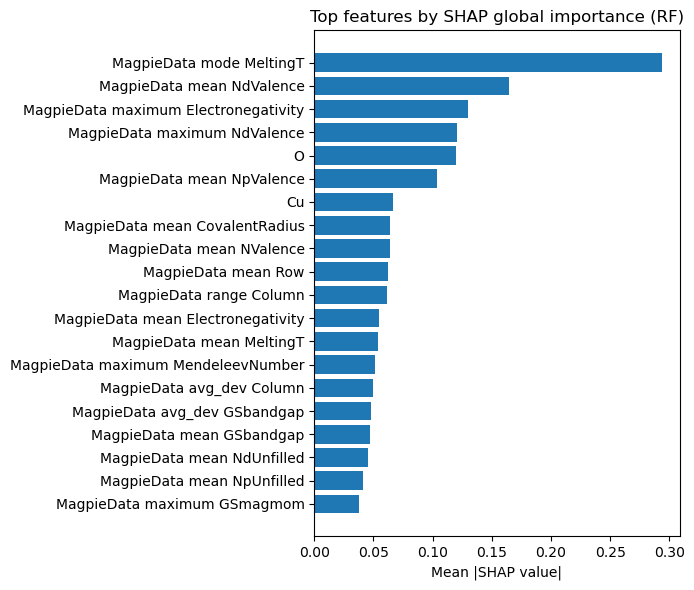

In [81]:
top_shap = shap_df.head(top_k).iloc[::-1]

plt.figure(figsize=(7,6))
plt.barh(top_shap["feature"], top_shap["mean_abs_shap"])
plt.xlabel("Mean |SHAP value|")
plt.title("Top features by SHAP global importance (RF)")
plt.tight_layout()
plt.savefig(RESULTS / "rf_shap_global_top20.png", dpi=300)
plt.show()

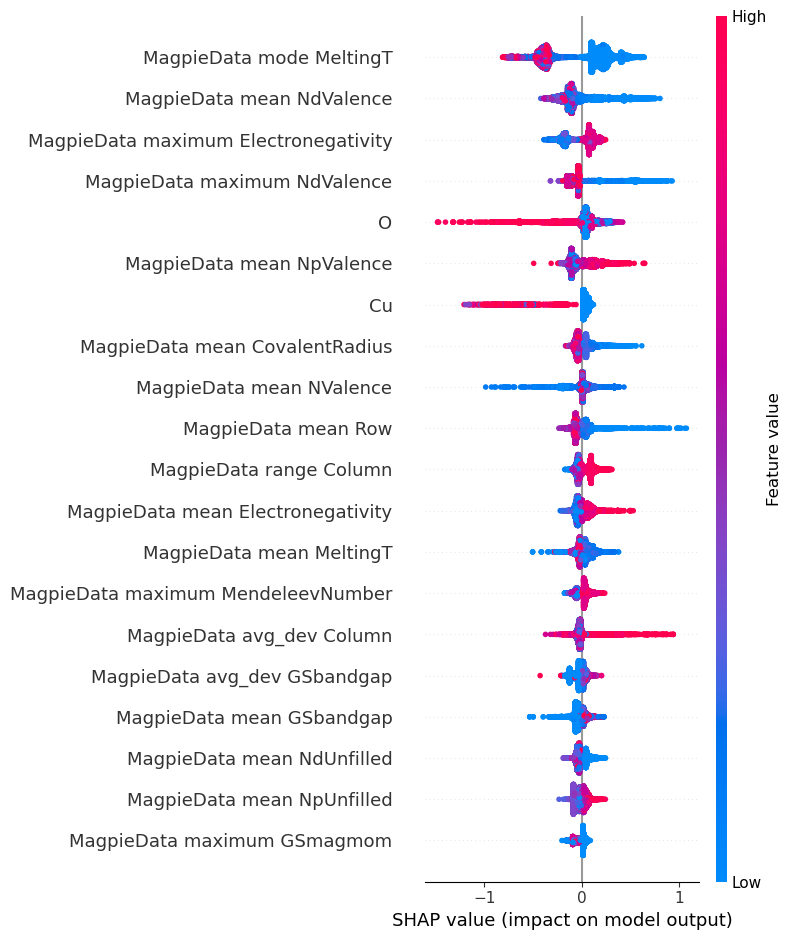

In [82]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    show=False)

plt.tight_layout()
plt.savefig(RESULTS / "rf_shap_summary.png", dpi=300)
plt.show()


=== Local SHAP for test index 0 (y=0.000, y_pred=-0.017) ===


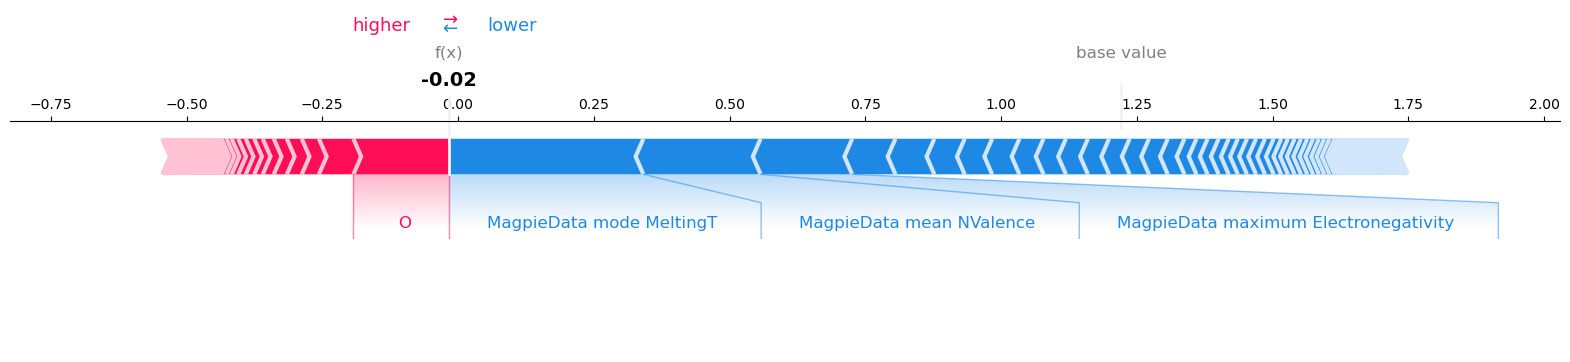


=== Local SHAP for test index 100 (y=0.000, y_pred=1.049) ===


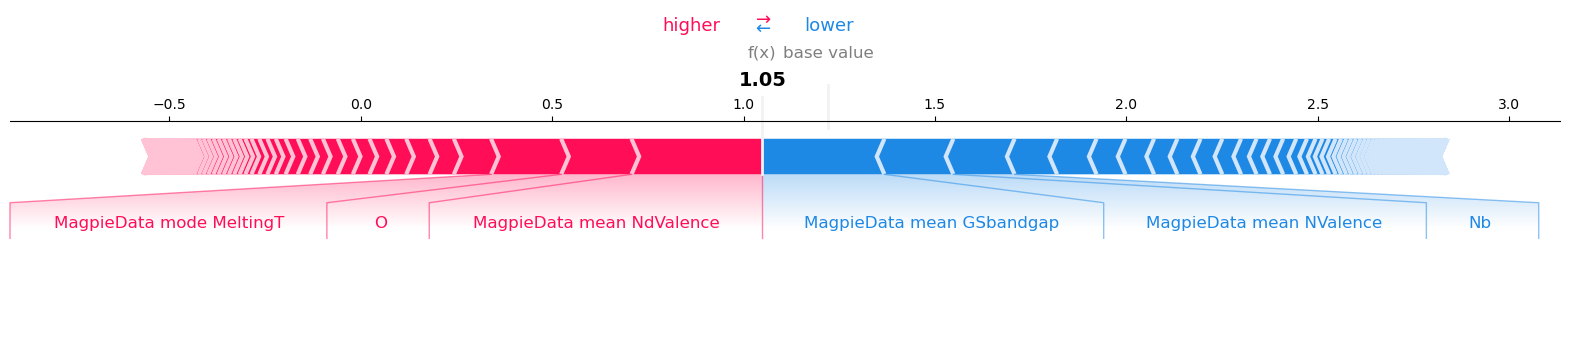


=== Local SHAP for test index 500 (y=0.000, y_pred=0.430) ===


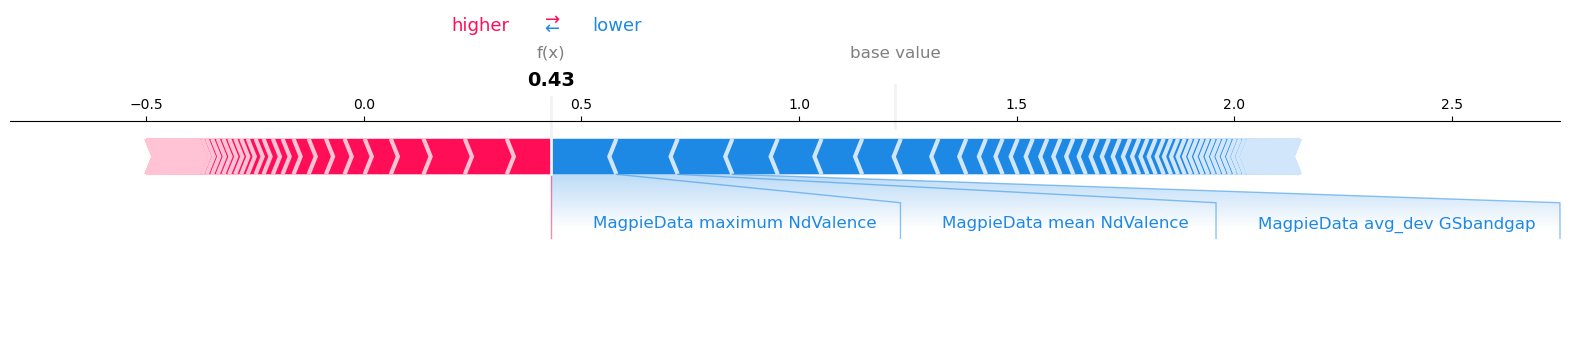

In [83]:
indices = [0, 100, 500] 

for idx in indices:
    print(f"\n=== Local SHAP for test index {idx} (y={y_shap[idx]:.3f}, y_pred={best_model.predict(X_shap[[idx]])[0]:.3f}) ===")
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx, :],
        feature_names=feature_names,
        matplotlib=True,
        show=True)